<div class="alert alert-block alert-success">
    <div style="font-size: 40px; font-weight: bold;">NEE</div>    
    <b>NOTE</b>: Check the variable `usecols` in `User settings` for info about variables used in this run.
</div>

**Feature Reduction and Gap-filling**

This script uses a datafile containing half-hourly fluxes and meteo data from the research site CH-AES (Aeschi, Switzerland).

Time Periods:
- Measurements 2019: raw data files from `2019051011.X52` to `2019072307.X00`
- Measurements 2020: raw data files from `2020051215.X15` to `2020110307.X00`

# User Settings
- `target` ... column name of the variable for which feature elimination and gap-filling will be performed
- `SELECT_YEAR` ... define year for analyses
- `DATAFILE` ... input, contains the source data
- `OUTFILE` ... output, will contain gap-filled data
- `usecols` ... column names of variables that will be ignored
- `keep_mgmt` ... options: `all` keeps all management, `bulk` keeps combined .MGMT column, `none` removes all management, `combos` keeps combined e.g. Nmin+Norg and also harvest
- `use_timesince_varsuse_timesince_vars` ... calculates e.g. the time since last management event, given as number or half-hours
- `timestamp_as_features` ... add timestamp info as features, e.g. the month is inserted as separate column and used as feature
- `include_rolling_variants` ... add rolling variants of variables as featuresAdd rolling variants of variables as features
- `include_lagged_variants` ... add lagged variants of the rolling variants as features, e.g. the 3-hour average ending 6-hours ago

In [1]:
# Year
SELECT_YEAR = 2019

# Variable of interest
target = 'NEE_flag0_ustar'

# Variables in DATAFILE that will be used, management data must be included here
# but will only be used if `keep_mgmt` is anything other than `none`.
usecols = [
    'PREC',
    'TA', 'Rg', 'VPD',
    'RH', 'PA',
    'TS_0.05',
    'TS_0.15', 'TS_0.30',
    'WFPS_0.05',
    'WFPS_0.15', 'WFPS_0.30',    
#     'GPP', 'Reco',
    'NEE_flag0_ustar',
#     'NEE', 'NEE_flag01_ustar', 'NEE_flag0', 'NEE_flag01',
#     'N2O_flag0_ustar',
#     'N2O_flag01', 'N2O_flag0',
#     'CH4_flag0_ustar',
#     'CH4_flag01', 'CH4_flag0',
    'herb', 'harvest', 'Nmin', 'Norg', 'Nfert', 'soil', 'sow',
#     'veg.height', 'lai'
]

# Use management info
keep_mgmt = 'bulk'  
use_timesince_vars = True

# Random forest settings
timestamp_as_features = False  
include_rolling_variants = False
include_lagged_variants = False

# Files
DATAFILE = "/home/jovyan/work/ms-ch-aes/data/ch-aes-fluxes-co2-n2o-ch4-and-meteo-2019-2020/CH-AES_2019_2020_data_for_analysis_20211127.csv"
OUTFILE = "_del.csv"

In [2]:
# # Complete list of variables

# usecols = [
#     'PREC',
#     'TA', 'RH', 'PA', 'Rg', 'VPD',
#     'TS_0.05',
#     'TS_0.15', 'TS_0.30',
#     'WFPS_0.05',
#     'WFPS_0.15', 'WFPS_0.30',    
#     'GPP', 'Reco',
#     'NEE_flag0_ustar',
#     'NEE', 'NEE_flag01_ustar', 'NEE_flag0', 'NEE_flag01',
#     'N2O_flag0_ustar',
#     'N2O_flag01', 'N2O_flag0',
#     'CH4_flag0_ustar',
#     'CH4_flag01', 'CH4_flag0',
#     'herb', 'harvest', 'Nmin', 'Norg', 'Nfert', 'soil', 'sow',
#     'veg.height', 'lai'
# ]

# Setup

## Imports

In [3]:
import os
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 99)
pd.set_option('display.max_rows', 99)

import warnings
warnings.filterwarnings('ignore')

from pkgs.randomforest_ts import RandomForestTS  # From DIIVE

In [4]:
print(f"Working directory: {os.getcwd()}")

Working directory: /home/jovyan/work/ms-ch-aes/notebooks


## Load data from file
Load the original data file.

In [5]:
date_parser = lambda c: pd.to_datetime(c, format='%Y-%m-%d %H:%M:%S', errors='coerce')
source_df = pd.read_csv(DATAFILE, index_col=0, parse_dates=True, na_values=[-9999, 'NA'], date_parser=date_parser)
print(f"\nLoaded data from file <b>s</b>{DATAFILE}\n")
print(f"\nData columns with original column names:\n{list(source_df.columns)}\n\n")
display(source_df)


Loaded data from file <b>s</b>/home/jovyan/work/ms-ch-aes/data/ch-aes-fluxes-co2-n2o-ch4-and-meteo-2019-2020/CH-AES_2019_2020_data_for_analysis_20211127.csv


Data columns with original column names:
['TA', 'RH', 'PA', 'Rg', 'TS_0.05', 'TS_0.15', 'TS_0.30', 'WFPS_0.05', 'WFPS_0.15', 'WFPS_0.30', 'PREC', 'VPD', 'NEE', 'GPP', 'Reco', 'NEE_flag01_ustar', 'NEE_flag0_ustar', 'NEE_flag0', 'NEE_flag01', 'N2O_flag01', 'N2O_flag0', 'N2O_flag0_ustar', 'CH4_flag01', 'CH4_flag0', 'CH4_flag0_ustar', 'herb', 'harvest', 'Nmin', 'Norg', 'Nfert', 'soil', 'sow', 'veg.height', 'lai']




,TA,RH,PA,Rg,TS_0.05,TS_0.15,...,Norg,Nfert,soil,sow,veg.height,lai
TIMESTAMP,,,,,,,,,,,,,
2019-05-08 15:45:00,10.233333,94.266667,94.953333,45.000000,11.933333,11.800000,...,0,0,0,0,0.000000,0.000000
2019-05-08 16:15:00,10.100000,95.333333,94.940000,45.000000,11.900000,11.800000,...,0,0,0,0,0.011012,0.000707
2019-05-08 16:45:00,10.133333,96.033333,94.956667,39.666667,11.866667,11.700000,...,0,0,0,0,0.022031,0.001414
2019-05-08 17:15:00,10.133333,96.200000,95.003333,36.666667,11.766667,11.700000,...,0,0,0,0,0.033059,0.002120
2019-05-08 17:45:00,10.166667,96.000003,95.063333,21.333333,11.700000,11.633333,...,0,0,0,0,0.044094,0.002827
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03 10:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0.000000,0.000000
2020-11-03 11:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0.000000,0.000000
2020-11-03 11:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0.000000,0.000000


### Sanitize original timestamp

**Check timestamp index for erroneous timestamps**:
Timestamp is checked for duplicates and timestamp NaTs ("not a time").

In [6]:
# Remove duplicates, keep first
locs_duplicates = source_df.index.duplicated(keep='first')
print(f"Found duplicates in index: {locs_duplicates.sum()}")
source_df = source_df[~locs_duplicates]

# Remove NaTs
locs_nats = source_df.index.isnull()
print(f"Found duplicates in index: {locs_nats.sum()}")
source_df = source_df[~locs_nats]

Found duplicates in index: 1
Found duplicates in index: 1


**Sort timestamp**: ascending order

In [7]:
# Sort timestamp index
source_df = source_df.sort_index(ascending=True)

### Check data

**Data description**:

In [8]:
source_df.describe()

,TA,RH,PA,Rg,TS_0.05,TS_0.15,...,Norg,Nfert,soil,sow,veg.height,lai
count,24461.000000,24475.000000,24465.000000,24513.000000,23939.000000,23939.000000,...,26153.000000,26153.000000,26153.000000,26153.000000,26153.000000,26153.000000
mean,12.936030,76.026378,96.175843,160.765543,15.239136,15.135057,...,0.001835,0.002753,0.003671,0.001835,45.966101,0.687314
std,7.459213,17.023136,0.683389,239.514489,6.817599,6.160020,...,0.042803,0.052398,0.060476,0.042803,99.785481,1.232336
min,-5.333333,24.966667,92.886667,0.000000,1.900000,3.002778,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.466667,63.266667,95.846667,0.000000,10.216389,10.465834,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.665000,81.100000,96.248277,14.333333,15.233333,15.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.017778,90.382222,96.580504,252.961103,20.100556,20.233611,...,0.000000,0.000000,0.000000,0.000000,17.732256,0.626979
max,36.200000,100.400000,98.096667,959.649957,38.166667,31.100000,...,1.000000,1.000000,1.000000,1.000000,323.071936,4.180000


**Available values by year**:

In [9]:
source_df.groupby(source_df.index.year).count()

,TA,RH,PA,Rg,TS_0.05,TS_0.15,...,Norg,Nfert,soil,sow,veg.height,lai
TIMESTAMP,,,,,,,,,,,,,
2019,11305,11305,11305,11319,11246,11246,...,11393,11393,11393,11393,11393,11393
2020,13156,13170,13160,13194,12693,12693,...,14760,14760,14760,14760,14760,14760


**Plot some columns**:

array([<AxesSubplot:xlabel='TIMESTAMP'>, <AxesSubplot:xlabel='TIMESTAMP'>],
      dtype=object)

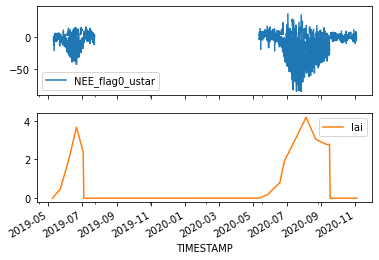

In [10]:
source_df[['NEE_flag0_ustar', 'lai']].plot(subplots=True)

## Prepare work dataset
Prepare dataset with reduced number of variables.  

**Copy**: always work on a copy, the loaded original data (`source_df`) remains untouched

In [11]:
# Make a copy
df = source_df.copy()

### Select columns and range

Remove unneeded columns:

In [12]:
df = df[usecols].copy()
# df.drop(dropcols, axis=1, inplace=True)

Rename the target column to 'target':

In [13]:
# Define and rename target column
df.rename(columns={target: 'target'}, inplace=True)

Get datetime of first and last available measurement of target:

In [14]:
_first_target_value_dt = df['target'].dropna().index[0]
_last_target_value_dt = df['target'].dropna().index[-1]
print(f"First measured value of target: {_first_target_value_dt}")
print(f"Last measured value of target: {_last_target_value_dt}")
print(f"Maximum value in target: {df['target'].max()}")
print(f"Minimum value in target: {df['target'].min()}")

First measured value of target: 2019-05-10 12:45:00
Last measured value of target: 2020-11-03 07:45:00
Maximum value in target: 40.28416
Minimum value in target: -83.684132


### Convert flux units
- from `umol m-2 s-1` to `nmol m-2 s-1`:

In [15]:
factor = 1000
if not 'NEE' in target:  # Do not convert for CO2 flux
    df['target'] = df['target'].multiply(factor)  
    print(f"Multiplied {target} by {factor}")
else:
    print(f"No conversion for {target}")        

No conversion for NEE_flag0_ustar


### Remove outliers
Flux data were already despiked. However we need to check if there are still problematic outliers in the dataset. Let's look at the 5 lowest values in target, to spot problematic outliers:

In [16]:
display(df['target'].sort_values(ascending=True).dropna().head(5))
display(df['target'].sort_values(ascending=True).dropna().tail(5))

TIMESTAMP
2020-07-26 10:15:00   -83.684132
2020-07-18 11:45:00   -83.451174
2020-07-22 10:15:00   -82.403032
2020-07-18 12:15:00   -82.274340
2020-07-23 13:45:00   -81.406003
Name: target, dtype: float64

TIMESTAMP
2020-07-26 19:15:00    30.233769
2020-07-26 19:45:00    32.991829
2020-07-02 23:15:00    34.688850
2020-07-22 00:45:00    37.585810
2020-07-28 02:15:00    40.284160
Name: target, dtype: float64

If needed, remove still existing problematic outliers:

In [17]:
if 'N2O' in target:
    df.loc[df['target'] < -2, ['target']] = np.nan  # For N2O, remove 
elif 'CH4' in target:
    df.loc[df['target'] < -30, ['target']] = np.nan  # For CH4, remove     
    df.loc[df['target'] > 100, ['target']] = np.nan  # For CH4, remove     
else:
    print(f"No left-over outliers removed from {target}.")        

No left-over outliers removed from NEE_flag0_ustar.


In [18]:
# Check again
display(df['target'].sort_values(ascending=True).dropna().head(5))
display(df['target'].sort_values(ascending=True).dropna().tail(5))

TIMESTAMP
2020-07-26 10:15:00   -83.684132
2020-07-18 11:45:00   -83.451174
2020-07-22 10:15:00   -82.403032
2020-07-18 12:15:00   -82.274340
2020-07-23 13:45:00   -81.406003
Name: target, dtype: float64

TIMESTAMP
2020-07-26 19:15:00    30.233769
2020-07-26 19:45:00    32.991829
2020-07-02 23:15:00    34.688850
2020-07-22 00:45:00    37.585810
2020-07-28 02:15:00    40.284160
Name: target, dtype: float64

### Add Management Info
Since management was taking place before the first flux measurements, the date range  
of the dataset is expanded and management dates are filled in. This way certain parameters  
can be calcualted, e.g. *time since last fertilization* **before** flux measurements.

<div class="alert alert-block alert-success"><b>Management events:</b> On days when management events took place, the management flag is set to 1 for all half-hours during daytime between 8:15 and 19:45.</div>

#### Expand date range
The timestamp in the data is expanded to also include management events before the first flux measurement.

Create a small, empty dataframe that is later used for expansion of the original data:

In [19]:
# Create date range for start of dataset
# Date of first known management at the site:
_start = dt.datetime(2019, 4, 23, 8, 15)  

# Last day with data:
_end = df.index[0]

# Generate continuous, half-hourly timestamp index starting at the date of
# the first known management and ending on the day when the last data were recorded:
_index = pd.date_range(_start, _end, freq='30T')
_index = _index[0:-1]  # Remove last entry, already in df.index

# Use created date range to build an empty dataframe with the same columns as the available data
_expansion_df = pd.DataFrame(index=_index, columns=df.columns)
_expansion_df

,PREC,TA,Rg,VPD,RH,PA,...,harvest,Nmin,Norg,Nfert,soil,sow
2019-04-23 08:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-23 08:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-23 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-23 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-23 10:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-08 13:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-08 13:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-08 14:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-08 14:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN


Add the expansion dataframe to the measured data:

In [20]:
df = pd.concat([df, _expansion_df], axis=0).sort_index()

With the exansion dataframe added, the data now starts at the date of first management, and ends with the date of last flux measurement:

In [21]:
# Check
display(df.head(3))
display(df.tail(3))

,PREC,TA,Rg,VPD,RH,PA,...,harvest,Nmin,Norg,Nfert,soil,sow
2019-04-23 08:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-23 08:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-23 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN


,PREC,TA,Rg,VPD,RH,PA,...,harvest,Nmin,Norg,Nfert,soil,sow
2020-11-03 11:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0
2020-11-03 12:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0
2020-11-03 12:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0


#### Soil Management
- Ploughing
- Soil preparation

In [22]:
# Remove current soil column
df = df.drop(['soil'], axis=1)

# Ploughing
df['.ploughing'] = 0  # New column
df.loc['2020-05-08 08:15:00':'2020-05-08 19:45:00', '.ploughing'] = 1  # Ploughing on 8 May 2020

# Soil preparation
df['.soilprep'] = 0  # New column
df.loc['2019-08-03 08:15:00':'2019-08-03 19:45:00', '.soilprep'] = 1  # Soil preparation on 3 Aug 2019
df.loc['2020-05-09 08:15:00':'2020-05-09 19:45:00', '.soilprep'] = 1  # Soil preparation on 9 May 2020
df.loc['2020-10-21 08:15:00':'2020-10-21 19:45:00', '.soilprep'] = 1  # Soil preparation on 21 Oct 2020

# Combined ploughing and soil preparation (they don't overlap)
df['.ploughing+soilprep'] = df['.ploughing'] + df['.soilprep']

#### Fertilization
- Organic fertilizer
- Mineral fertilizer

In [23]:
# Remove current fertilizer columns
df = df.drop(['Nfert'], axis=1)
df = df.drop(['Norg'], axis=1)
df = df.drop(['Nmin'], axis=1)

# Organic fertilizer
df['.Norg'] = 0  # New column
df.loc['2020-05-08 08:15:00':'2020-05-08 19:45:00', '.Norg'] = 1  # Solid manure on 8 May 2020
df.loc['2020-10-20 08:15:00':'2020-10-20 19:45:00', '.Norg'] = 1  # Liquid manure on 20 Oct 2020

# Mineral fertilizer
df['.Nmin'] = 0  # New column
df.loc['2020-05-22 08:15:00':'2020-05-22 19:45:00', '.Nmin'] = 1  # Urea on 22 May 2020

# Combined organic and mineral fertilizer (they don't overlap)
df['.Norg+Nmin'] = df['.Norg'] + df['.Nmin']  # Overrides the column that is already in df

#### Harvest

In [24]:
# Remove current harvest column
df = df.drop(['harvest'], axis=1)

# Harvest
df['.harvest'] = 0  # Sets the column that is already in df to zero
df.loc['2019-07-03 08:15:00':'2019-07-03 19:45:00', '.harvest'] = 1  # Harvest on 3 Jul 2019
df.loc['2019-09-15 08:15:00':'2019-09-15 19:45:00', '.harvest'] = 1  # Harvest on 15 Sep 2019
df.loc['2019-10-30 08:15:00':'2019-10-30 19:45:00', '.harvest'] = 1  # Harvest on 30 Oct 2019
df.loc['2020-05-06 08:15:00':'2020-05-06 19:45:00', '.harvest'] = 1  # Harvest on 6 May 2020
df.loc['2020-09-15 08:15:00':'2020-09-16 19:45:00', '.harvest'] = 1  # Harvest on 15 and 16 Sep 2020, harvest took place over two days

#### Sowing

In [25]:
# Remove current sowing column
df = df.drop(['sow'], axis=1)

df['.sowing'] = 0  # New column
df.loc['2019-04-23 08:15:00':'2019-04-23 19:45:00', '.sowing'] = 1  # Sowing on 23 Apr 2019
df.loc['2019-08-04 08:15:00':'2019-08-04 19:45:00', '.sowing'] = 1  # Sowing on 4 Aug 2019
df.loc['2020-05-09 08:15:00':'2020-05-09 19:45:00', '.sowing'] = 1  # Sowing on 9 May 2020

#### Herbicide / Insecticide

In [26]:
# Remove current herbicide / Insecticide column
df = df.drop(['herb'], axis=1)

# df['herb'] = 0  # Sets the column that is already in df to zero
# df.loc['2020-05-22 08:15:00':'2020-05-22 19:45:00', 'herb'] = 1  # Herbicide/insecticide on 22 May 2020

#### Combined Management

In [27]:
df['.MGMT'] = df['.ploughing'] + df['.soilprep'] + df['.Norg'] + df['.Nmin'] + df['.harvest'] + df['.sowing']  # Without 'herb'

#### Plot
The plot shows all management events in the dataset. The data column for each event is set to `1` during daytime on the day of management, `0` on otherwise. The column `.MGMT` includes all managements and is simply the sum over all management events and for each half-hour (this means it can become >1 in case e.g. two different management events occurred on the same day).

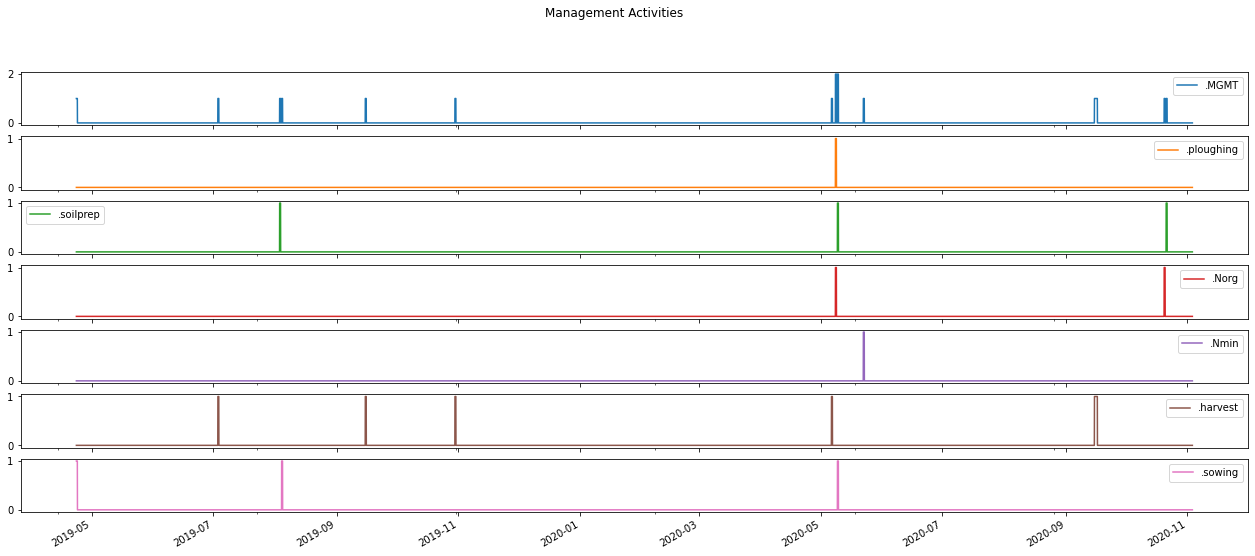

In [28]:
df[['.MGMT', '.ploughing',  '.soilprep', '.Norg', '.Nmin', '.harvest', '.sowing']].plot(figsize=(22,9), subplots=True, title="Management Activities");

#### Keep Management?

In [29]:
# List of management columns:
# ['.MGMT', '.ploughing',  '.soilprep', '.Norg', '.Nmin', '.harvest', '.sowing', '.ploughing+soilprep', '.Norg+Nmin']

if keep_mgmt == 'all':
    print("Keeping all management in dataset.")
    pass

elif keep_mgmt == 'bulk':  # Keep .MGMT only
    print("Keeping .MGMT column only.")
    df.drop(['.ploughing',  '.soilprep', '.Norg', '.Nmin', '.harvest', '.sowing', '.ploughing+soilprep', '.Norg+Nmin'], axis=1, inplace=True)

elif keep_mgmt == 'none':
    print("Removing all management from dataset.")
    df.drop(['.MGMT', '.ploughing',  '.soilprep', '.Norg', '.Nmin', '.harvest', '.sowing', '.ploughing+soilprep', '.Norg+Nmin'], axis=1, inplace=True)

elif keep_mgmt == 'combos':
    print("Keeping combos.")
    df.drop(['.MGMT', '.ploughing',  '.soilprep', '.Norg', '.Nmin', '.sowing'], axis=1, inplace=True)    

Keeping .MGMT column only.


#### Check variables in work dataset

In [30]:
df.columns

Index(['PREC', 'TA', 'Rg', 'VPD', 'RH', 'PA', 'TS_0.05', 'TS_0.15', 'TS_0.30', 'WFPS_0.05', 'WFPS_0.15', 'WFPS_0.30', 'target', '.MGMT'], dtype='object')

### Calculate Additional Variables

#### Add Day/Night Groups

<div class="alert alert-block alert-success">
    <b>NOTE</b>: To make sure each day and night have the same amount of potential values:</br>
    <ul>
        <li><b>Daytime</b> is defined as the time between 08:15 and 19:45.</li>
        <li><b>Nighttime</b> is defined as the time between 20:15 and 07:45 the following day.</li>
    </ul>
</div>

Accordingly, each day has 24 half-hourly values, and each night has 24 half-hourly values.

This step also calcualted the `.grp` variables, assigns a unique number to each daytime and to each nighttime. For example, the first daytime has id `1`, the following nighttime id `2`, the following daytime id `3`, the following nighttime id `4`, etc...

In [31]:
# New df to assemble day/night info, will be merged with main data later
_daynight_grps_df = pd.DataFrame(index=df.index)

# Determine day and night (1=day, 0=night)
_mask_daytime_rows = (df.index.hour >= 8) & (df.index.hour <= 19)
_daynight_grps_df.loc[_mask_daytime_rows, '.daynight'] = 1
_daynight_grps_df.loc[~_mask_daytime_rows, '.daynight'] = 0

# Consecutive days/nights
_daynight_grps_df['.grp'] = (_daynight_grps_df['.daynight'].diff(1) != 0).astype('int').cumsum()

# # One Hot Encoding
# _daynight_grps_df = pd.get_dummies(_daynight_grps_df, columns=["_daynight"], prefix="_daynight")

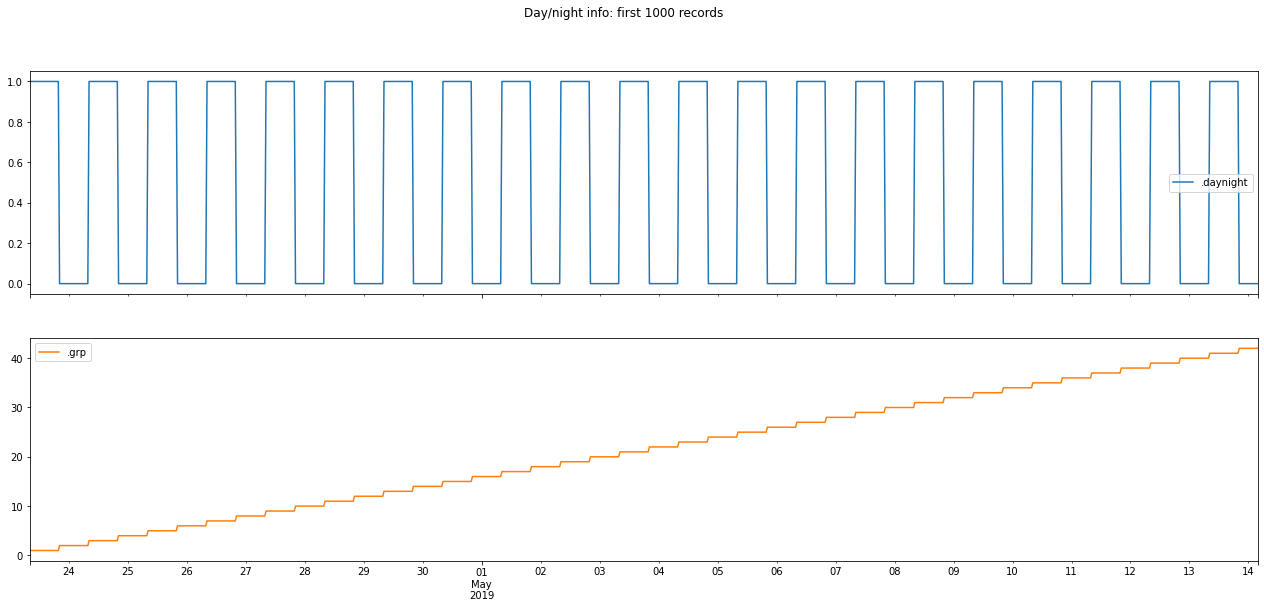

In [32]:
_daynight_grps_df.iloc[0:1000].plot(subplots=True, figsize=(22,9), title="Day/night info: first 1000 records");

#### Add Group Start Times
Add starting datetime, month and week for each `.grp` group.

Create new df to assemble time info, will be merged with main data later:

In [33]:
_timeinfo_df = pd.DataFrame(index=df.index)

Add timestamp index and `.grp` as data columns:

In [34]:
_timeinfo_df['.TIMESTAMP'] = _timeinfo_df.index
_timeinfo_df['.grp'] = _daynight_grps_df['.grp'].copy()

For each `.grp`, get its starting datetime and store as dict:

In [35]:
_grp_start = _timeinfo_df.groupby('.grp')['.TIMESTAMP'].idxmin()
_map_grp_start = _grp_start.to_dict()
print("First 3 entries in dict:")
for x in list(_map_grp_start)[0:3]:
    print(f".grp: {x}, start datetime: {_map_grp_start[x]}")

First 3 entries in dict:
.grp: 1, start datetime: 2019-04-23 08:15:00
.grp: 2, start datetime: 2019-04-23 20:15:00
.grp: 3, start datetime: 2019-04-24 08:15:00


The dict can now be used as a lookup table to assign the start datetime to each `.grp`:

In [36]:
_timeinfo_df['.grp_start'] = _timeinfo_df['.grp'].map(_map_grp_start)

Also add start month and week for each `.grp`:

In [37]:
_timeinfo_df['.grp_start_month'] = _timeinfo_df['.grp_start'].dt.month
_timeinfo_df['.grp_start_week'] = _timeinfo_df['.grp_start'].dt.isocalendar()['week']

Plot:

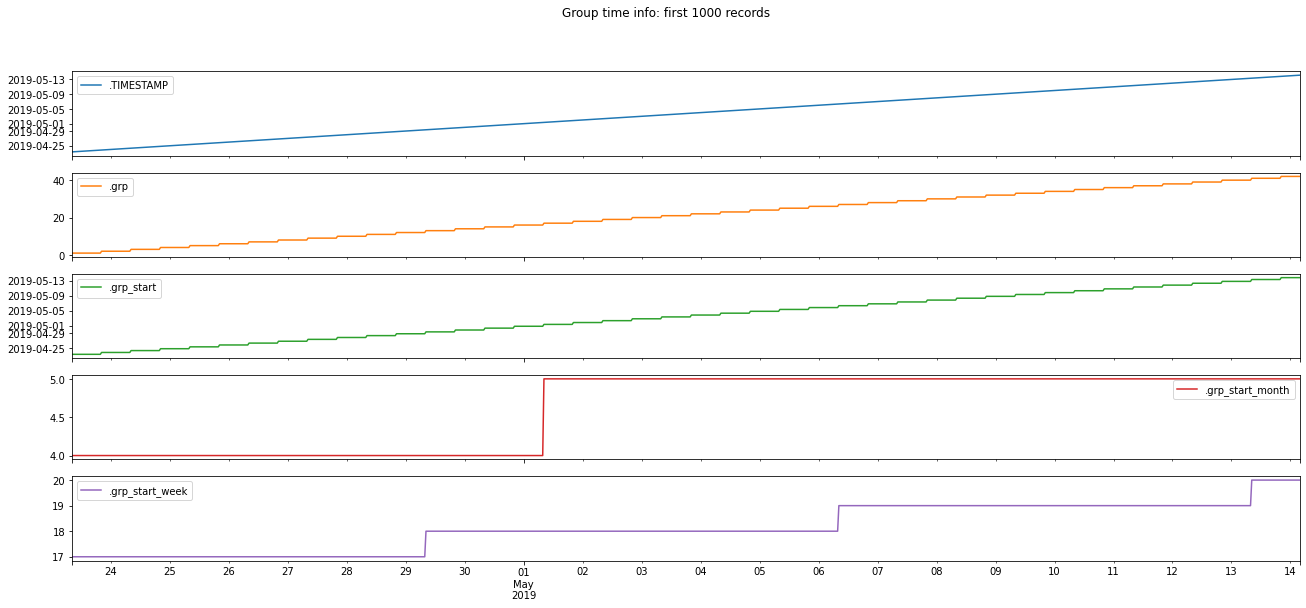

In [38]:
_timeinfo_df.iloc[0:1000].plot(subplots=True, figsize=(22,9), title="Group time info: first 1000 records");

#### Add Time Since
Count time (records) since last occurrence, e.g. time since last precipitation.

Variables for which timesince will be calculated:

In [39]:
_list_timesince_vars = ['PREC', '.MGMT', '.ploughing',  '.soilprep', '.Norg', '.Nmin', '.harvest', '.sowing', '.ploughing+soilprep', '.Norg+Nmin']

New df to assemble timesince, will be merged with main data later

In [40]:
_timesince_df = pd.DataFrame()

Function to calculate timesince:

In [41]:
def timesince(series):
    flag = series.copy()
    flag.loc[series > 0] = 0  # Set flag to zero where series > 0, for correct timesince counting
    flag.loc[series == 0] = 1  # Set flag to one where series = 0
    flag.loc[series.isnull()] = 1  # Set flag to one where series is missing
    # kudos, fantastic: https://stackoverflow.com/questions/27626542/counting-consecutive-positive-value-in-python-array
    timesince = flag * (flag.groupby((flag != flag.shift()).cumsum()).cumcount() + 1)
    return timesince

Calculate timesince variables:

PREC
.MGMT
['.timesince_PREC', '.timesince_.MGMT']


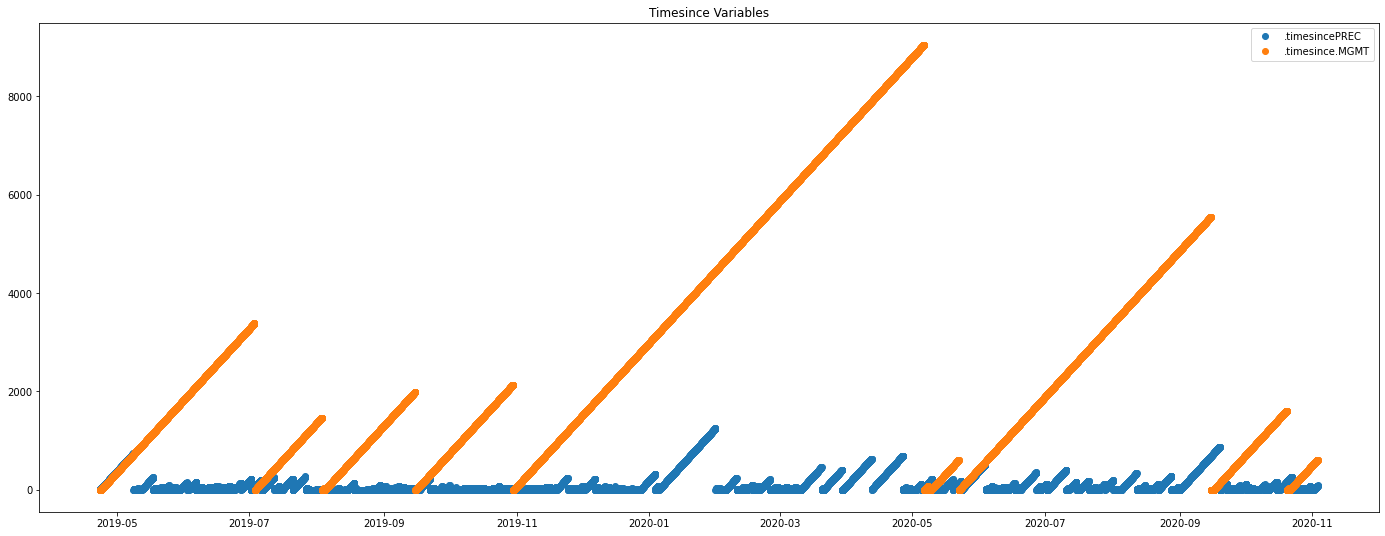

In [42]:
if use_timesince_vars:
    for v in _list_timesince_vars:
        if v in df.columns:
            print(v)
            _timesince_df[v] = df[v].copy()        

    # Calculate timesince for selected vars
    for v in _timesince_df.columns:
        var_timesince = f'.timesince_{v}'
        _timesince_df[var_timesince] = timesince(series=_timesince_df[v])    

    # Get list of timesince vars
    _timesince_cols = [x for x in _timesince_df.columns if '.timesince_' in x]    
    print(_timesince_cols)

    # Plot
    plt.figure(figsize=(24, 9))
    plt.title("Timesince Variables")
    for col in _timesince_cols:
        label = col.replace('_', '')  # Matplotlib legend cannot show variables starting with an _underscore
        plt.plot_date(_timesince_df.index, _timesince_df[col], label=label)
    plt.legend();
else:
    print("No timesince variables calculated.")
        

#### Add To Subset
Add created additional variables to subset.

In [43]:
# Add to main data
df = pd.concat([df, _daynight_grps_df, _timeinfo_df, _timesince_df], axis=1)
df = df.loc[:,~df.columns.duplicated()]  # Some columns are now duplicated due to the merging, remove them
df = df.drop(['.TIMESTAMP', '.grp_start', '.grp', '.grp_start_month', '.grp_start_week'], axis=1)  # Remove for now

### Check work dataset contents

In [44]:
pd.set_option('display.max_columns', 99)
pd.set_option('display.max_rows', 99)
display(df.head(3))
display(df.columns)

,PREC,TA,Rg,VPD,RH,PA,TS_0.05,TS_0.15,TS_0.30,WFPS_0.05,WFPS_0.15,WFPS_0.30,target,.MGMT,.daynight,.timesince_PREC,.timesince_.MGMT
2019-04-23 08:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,0
2019-04-23 08:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,2.0,0
2019-04-23 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,3.0,0


Index(['PREC', 'TA', 'Rg', 'VPD', 'RH', 'PA', 'TS_0.05', 'TS_0.15', 'TS_0.30', 'WFPS_0.05', 'WFPS_0.15', 'WFPS_0.30', 'target', '.MGMT', '.daynight', '.timesince_PREC', '.timesince_.MGMT'], dtype='object')

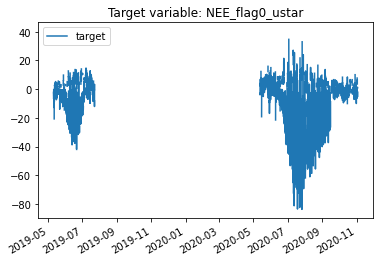

In [45]:
df[['target']].plot(title=f"Target variable: {target}");

# Random Forest

## Prepare Data Subset
Make subset of data that is used in RF.

In [46]:
# Make copy to work with
subset_df = df.copy()

In [47]:
# Select year
subset_df = subset_df.loc[subset_df.index.year == SELECT_YEAR]
  
if SELECT_YEAR == 2020:
    start_date = pd.to_datetime('2020-01-01 00:15:00')
    end_date = pd.to_datetime('2020-09-16 23:45')    
elif SELECT_YEAR == 2019:
    start_date = pd.to_datetime('2019-01-01 00:15:00')
    end_date = pd.to_datetime('2019-10-30 23:45')      

subset_df['temp_datetime_col'] = subset_df.index
subset_df.loc[(subset_df['temp_datetime_col'] > start_date) & (subset_df['temp_datetime_col'] < end_date)]  
subset_df = subset_df[subset_df['temp_datetime_col'].between(start_date, end_date)]
subset_df = subset_df.drop('temp_datetime_col', axis=1)

# Datetime of first and last available measurement of target
_first_target_value_dt = subset_df['target'].dropna().index[0]
_last_target_value_dt = subset_df['target'].dropna().index[-1]
print(f"First measured value of target: {_first_target_value_dt}")
print(f"Last measured value of target: {_last_target_value_dt}")

# Restrict time range to first and last available data point of target
subset_df = subset_df.loc[_first_target_value_dt:_last_target_value_dt]

First measured value of target: 2019-05-10 12:45:00
Last measured value of target: 2019-07-23 07:45:00


In [48]:
# Add second header row, needed for RandomForestTS class
lst_for_empty_units = []
for e in range(len(subset_df.columns)):  ## generate entry for all cols in df
    lst_for_empty_units.append('-')
subset_df.columns = [subset_df.columns, lst_for_empty_units]  ## conv column index to multiindex

In [49]:
# # subset_df.to_csv("test.csv")
# DAY_df = subset_df.copy()
# daynight_col = ('.daynight', '-')
# DAY_df = DAY_df.loc[DAY_df[daynight_col] == 0, :]
# DAY_df
# subset_df = DAY_df.copy()

## Model setup

In [50]:
target_col = ('target', '-')
rfts = RandomForestTS(df=subset_df,
                      target_col=target_col,
                      verbose=1,
                      random_state=42,
                      rfecv_step=1,
                      rfecv_min_features_to_select=20,
                      rf_rfecv_n_estimators=100,
                      rf_n_estimators=1000,
                      bootstrap=True)

## Rolling Variants

In [51]:
if include_rolling_variants:
    
    # No rolling variants for some vars
    _donotroll_ids = ['.timesince', '.MGMT', '.ploughing',  '.soilprep', '.Norg', '.Nmin', '.harvest', '.sowing', '.daynight']
    donotroll_cols = [target_col]
    for col in rfts.df.columns:
        if any(_donotroll_id in col[0] for _donotroll_id in _donotroll_ids):
            donotroll_cols.append(col)
    
    rfts.rolling_variants(records=6,
                          aggtypes=['mean'],
                          exclude_cols=donotroll_cols)    
else:
    print("No rolling variants calculated.")

No rolling variants calculated.


In [52]:
rfts.df.columns

MultiIndex([(            'PREC', '-'),
            (              'TA', '-'),
            (              'Rg', '-'),
            (             'VPD', '-'),
            (              'RH', '-'),
            (              'PA', '-'),
            (         'TS_0.05', '-'),
            (         'TS_0.15', '-'),
            (         'TS_0.30', '-'),
            (       'WFPS_0.05', '-'),
            (       'WFPS_0.15', '-'),
            (       'WFPS_0.30', '-'),
            (          'target', '-'),
            (           '.MGMT', '-'),
            (       '.daynight', '-'),
            ( '.timesince_PREC', '-'),
            ('.timesince_.MGMT', '-')],
           )

## Lagged Variants

In [53]:
if include_lagged_variants:       
    
    if include_rolling_variants:
        # Create lagged variants for rolling variants only
        exclude_cols = []
        [exclude_cols.append(col) for col in rfts.df.columns if 'r-' not in col[0]]
        print(f"No lagged variants will be created for the following columns:{exclude_cols}\n")
    
    rfts.steplagged_variants(stepsize=6,
                             stepmax=24,
                             exclude_cols=exclude_cols)
else:
    print("No lagged variants calculated.")

No lagged variants calculated.


In [54]:
list(rfts.df.columns)

[('PREC', '-'),
 ('TA', '-'),
 ('Rg', '-'),
 ('VPD', '-'),
 ('RH', '-'),
 ('PA', '-'),
 ('TS_0.05', '-'),
 ('TS_0.15', '-'),
 ('TS_0.30', '-'),
 ('WFPS_0.05', '-'),
 ('WFPS_0.15', '-'),
 ('WFPS_0.30', '-'),
 ('target', '-'),
 ('.MGMT', '-'),
 ('.daynight', '-'),
 ('.timesince_PREC', '-'),
 ('.timesince_.MGMT', '-')]

## Add Timestamp As Features

In [55]:
if timestamp_as_features:
    rfts.include_timestamp_as_features(doy_as_feature=True,
                                       week_as_feature=True,
                                       month_as_feature=True,
                                       hour_as_feature=True)

## Check

In [56]:
# [print(col) for col in rfts.df.columns]
pd.set_option('display.max_columns', 99)
pd.set_option('display.max_rows', 99)
display(rfts.df)
columns_in_dataset = list(rfts.df.columns)
# [print(col) for col in columns_in_dataset]
columns_in_dataset

,PREC,TA,Rg,VPD,RH,PA,TS_0.05,TS_0.15,TS_0.30,WFPS_0.05,WFPS_0.15,WFPS_0.30,target,.MGMT,.daynight,.timesince_PREC,.timesince_.MGMT
,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
2019-05-10 12:45:00,0.0,13.933333,674.333333,484.515,69.466667,95.733333,14.266667,11.833333,10.433333,57.503041,NaN,NaN,-6.310756,0,1.0,10.0,802
2019-05-10 13:15:00,0.0,14.700000,805.333333,528.064,68.333333,95.726667,14.833333,12.266667,10.500000,57.429442,NaN,NaN,-5.498100,0,1.0,11.0,803
2019-05-10 13:45:00,0.0,14.900000,606.000000,597.418,64.633340,95.726667,15.533333,12.666667,10.666667,57.298300,NaN,NaN,-2.451280,0,1.0,12.0,804
2019-05-10 14:15:00,0.0,15.333333,689.333333,671.624,61.333333,95.713333,15.900000,13.066667,10.766667,57.257234,NaN,NaN,-1.710270,0,1.0,13.0,805
2019-05-10 14:45:00,0.0,15.466667,467.000000,686.155,60.833333,95.713333,15.966667,13.400000,10.933333,57.100980,NaN,NaN,-3.713558,0,1.0,14.0,806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-23 05:45:00,0.0,15.866667,66.333333,170.148,90.533333,96.746667,21.300000,23.766667,24.200000,34.749342,45.074505,36.390485,NaN,0,0.0,95.0,932
2019-07-23 06:15:00,0.0,17.100000,120.333333,220.330,88.666667,96.736667,21.533333,23.533333,24.100000,34.749342,45.014036,36.356408,NaN,0,0.0,96.0,933
2019-07-23 06:45:00,0.0,18.466667,181.000000,359.502,83.033333,96.730000,22.100000,23.366667,24.000000,34.760933,44.983768,36.310943,NaN,0,0.0,97.0,934


[('PREC', '-'),
 ('TA', '-'),
 ('Rg', '-'),
 ('VPD', '-'),
 ('RH', '-'),
 ('PA', '-'),
 ('TS_0.05', '-'),
 ('TS_0.15', '-'),
 ('TS_0.30', '-'),
 ('WFPS_0.05', '-'),
 ('WFPS_0.15', '-'),
 ('WFPS_0.30', '-'),
 ('target', '-'),
 ('.MGMT', '-'),
 ('.daynight', '-'),
 ('.timesince_PREC', '-'),
 ('.timesince_.MGMT', '-')]

In [57]:
# rfts.df.plot(figsize=(16, 9), subplots=True);

## Feature Reduction
Identify most important features for predicting target.

In [58]:
rfts.feature_reduction()
reduced_df, feat_reduction_results = rfts.get_reduced_dataset()



[FEATURE REDUCTION]    START ==============================
[FEATURE REDUCTION]    Parameters:  {'cv': TimeSeriesSplit(max_train_size=None, n_splits=5), 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'mse', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': -1, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(n_jobs=-1, random_state=42), 'min_features_to_select': 20, 'n_jobs': -1, 'scoring': 'explained_variance', 'step': 1, 'verbose': 1}
[FEATURE REDUCTION]    Number of features *before* reduction:  16
[FEATURE REDUCTION]   

In [59]:
feat_reduction_results['feature_importances_after'].loc[feat_reduction_results['feature_importances_after']['importance'] > 0.01]

,feature,importance
2,"(Rg, -)",0.454758
15,"(.timesince_.MGMT, -)",0.400159
8,"(TS_0.30, -)",0.036549
14,"(.timesince_PREC, -)",0.020619
5,"(PA, -)",0.016620
4,"(RH, -)",0.013775
3,"(VPD, -)",0.013565
7,"(TS_0.15, -)",0.012239
11,"(WFPS_0.30, -)",0.011626


## Build Final Model

In [60]:
rfts.build_final_model()



[FINAL MODEL]    START ==============================
[FINAL MODEL]    Target column:  ('target', '-')  (1422 values)
[FINAL MODEL]    Number of features used in model:  9
[FINAL MODEL]    Names of features used in model:  [('Rg', '-'), ('.timesince_.MGMT', '-'), ('TS_0.30', '-'), ('.timesince_PREC', '-'), ('PA', '-'), ('RH', '-'), ('VPD', '-'), ('TS_0.15', '-'), ('WFPS_0.30', '-')]
[FINAL MODEL]    Model parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
[FINAL MODEL]    Model MAE:  0.7096699795867696
[FINAL MODEL]    Model MAPE:  -3.066%
[FINAL MODEL]    Model R2:  0.9924718772305545
[FINAL MODEL]    Model features:
               

## Fill gaps
Fill gaps in target variable, using the model with reduced features.

In [61]:
rfts.gapfilling()
gapfilled_df, gf_results = rfts.get_gapfilled_dataset()



[GAPFILLING]    START ==============================
Added timestamp as columns: [('.DOY', '[day_of_year]'), ('.WEEK', '[week_of_year]'), ('.MONTH', '[month]'), ('.HOUR', '[hour]')]
[GAPFILLING]    feature_names:  [('Rg', '-'), ('.timesince_.MGMT', '-'), ('TS_0.30', '-'), ('.timesince_PREC', '-'), ('PA', '-'), ('RH', '-'), ('VPD', '-'), ('TS_0.15', '-'), ('WFPS_0.30', '-')]
[GAPFILLING]    num_features:  9
[GAPFILLING]    first_timestamp:  2019-05-10 12:45:00
[GAPFILLING]    last_timestamp:  2019-07-23 07:45:00
[GAPFILLING]    max_potential_vals:  3543
[GAPFILLING]    target_numvals:  1641
[GAPFILLING]    target_numgaps:  1902
[GAPFILLING]    target_gapfilled_numvals:  3543
[GAPFILLING]    target_gapfilled_numgaps:  0
[GAPFILLING]    target_gapfilled_flag_notfilled:  1641
[GAPFILLING]    target_gapfilled_flag_with_hq:  1702
[GAPFILLING]    target_gapfilled_flag_with_fallback:  200
[GAPFILLING]    predictions_hq_numvals:  3124
[GAPFILLING]    predictions_hq_numgaps:  419
[GAPFILLING] 

In [62]:
gapfilled_df

,target,.predictions,.gap_predictions,QCF_target#gfRF,target#gfRF,.predictions_fallback,.gapfilled_cumulative
,-,[aux],[aux],[0=measured],-,[aux],[aux]
2019-05-10 12:45:00,-6.310756,NaN,NaN,0,-6.310756,-5.531648,-6.310756
2019-05-10 13:15:00,-5.498100,NaN,NaN,0,-5.498100,-4.152650,-11.808856
2019-05-10 13:45:00,-2.451280,NaN,NaN,0,-2.451280,-4.152650,-14.260136
2019-05-10 14:15:00,-1.710270,NaN,NaN,0,-1.710270,-3.188464,-15.970406
2019-05-10 14:45:00,-3.713558,NaN,NaN,0,-3.713558,-3.188464,-19.683964
...,...,...,...,...,...,...,...
2019-07-23 05:45:00,NaN,1.943273,1.943273,1,1.943273,3.870298,-5154.194193
2019-07-23 06:15:00,NaN,0.790219,0.790219,1,0.790219,0.354283,-5153.403974
2019-07-23 06:45:00,NaN,-0.407605,-0.407605,1,-0.407605,0.354283,-5153.811580


## Save To File

In [63]:
gapfilled_df.to_csv(OUTFILE)

## Summary

In [64]:
gf_results

{'feature_names': [('Rg', '-'),
  ('.timesince_.MGMT', '-'),
  ('TS_0.30', '-'),
  ('.timesince_PREC', '-'),
  ('PA', '-'),
  ('RH', '-'),
  ('VPD', '-'),
  ('TS_0.15', '-'),
  ('WFPS_0.30', '-')],
 'num_features': 9,
 'first_timestamp': Timestamp('2019-05-10 12:45:00'),
 'last_timestamp': Timestamp('2019-07-23 07:45:00'),
 'max_potential_vals': 3543,
 'target_numvals': 1641,
 'target_numgaps': 1902,
 'target_gapfilled_numvals': 3543,
 'target_gapfilled_numgaps': 0,
 'target_gapfilled_flag_notfilled': 1641,
 'target_gapfilled_flag_with_hq': 1702,
 'target_gapfilled_flag_with_fallback': 200,
 'predictions_hq_numvals': 3124,
 'predictions_hq_numgaps': 419,
 'predictions_fallback_numvals': 3543,
 'predictions_fallback_numgaps': 0}

In [65]:
# Flag info
_flag = gapfilled_df[('QCF_target#gfRF', '[0=measured]')]
_unique_values = pd.unique(_flag.values.ravel())
_counts_series = pd.Series(index=_unique_values, dtype=int)
_counts_series = _flag.value_counts(dropna=False)
_counts_series

1    1702
0    1641
2     200
Name: (QCF_target#gfRF, [0=measured]), dtype: int64

In [66]:
list(gapfilled_df.columns)

[('target', '-'),
 ('.predictions', '[aux]'),
 ('.gap_predictions', '[aux]'),
 ('QCF_target#gfRF', '[0=measured]'),
 ('target#gfRF', '-'),
 ('.predictions_fallback', '[aux]'),
 ('.gapfilled_cumulative', '[aux]')]

### Plot: Overview

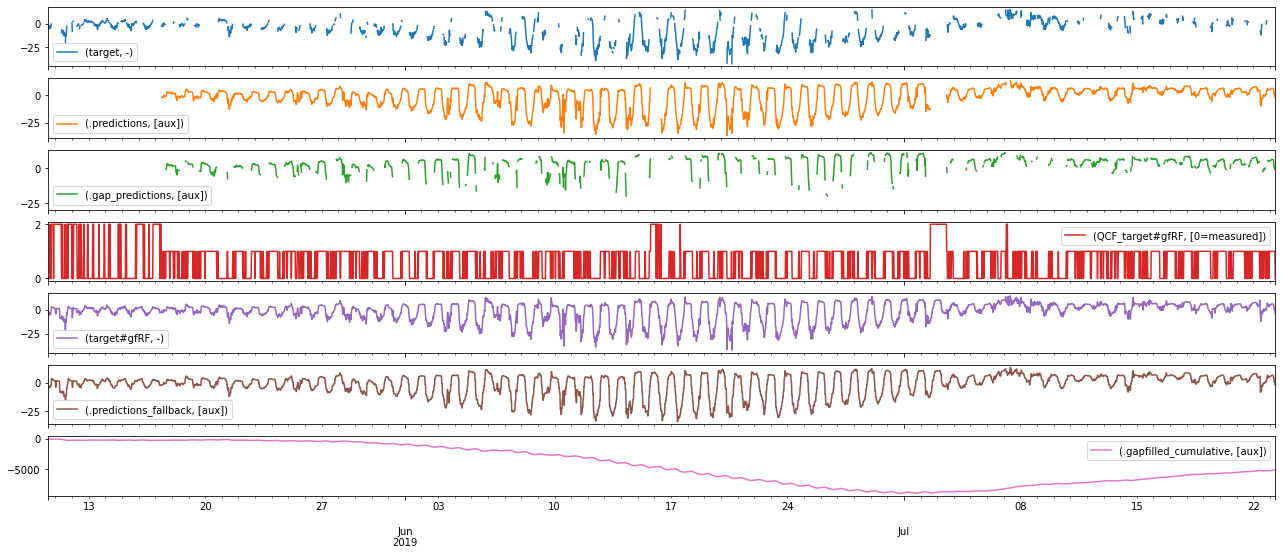

In [67]:
gapfilled_df.plot(subplots=True, figsize=(22, 9));

### Plot: Predictions vs. Target

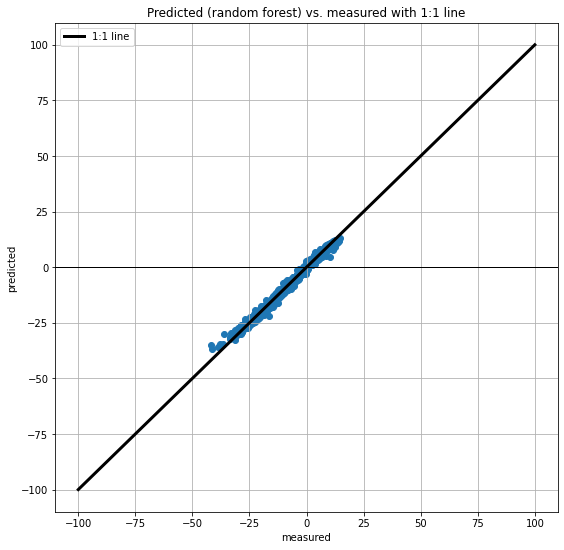

In [68]:
# Plot all targets vs. predictions
x_col = ('target', '-')
y_col = ('.predictions', '[aux]')
plt.figure(figsize=(9, 9))
plt.scatter(gapfilled_df[x_col], gapfilled_df[y_col])
plt.title("Predicted (random forest) vs. measured with 1:1 line")
plt.axhline(0, color='black', lw=1)
plt.plot([-100,100],[-100,100], 'black', linewidth=3, label="1:1 line", ls="-")
plt.xlabel("measured")
plt.ylabel("predicted")
# plt.xlim(-70, 20)
# plt.ylim(-70, 20)
plt.grid()
plt.legend();

### Plot: Measured And Gap-filled Values

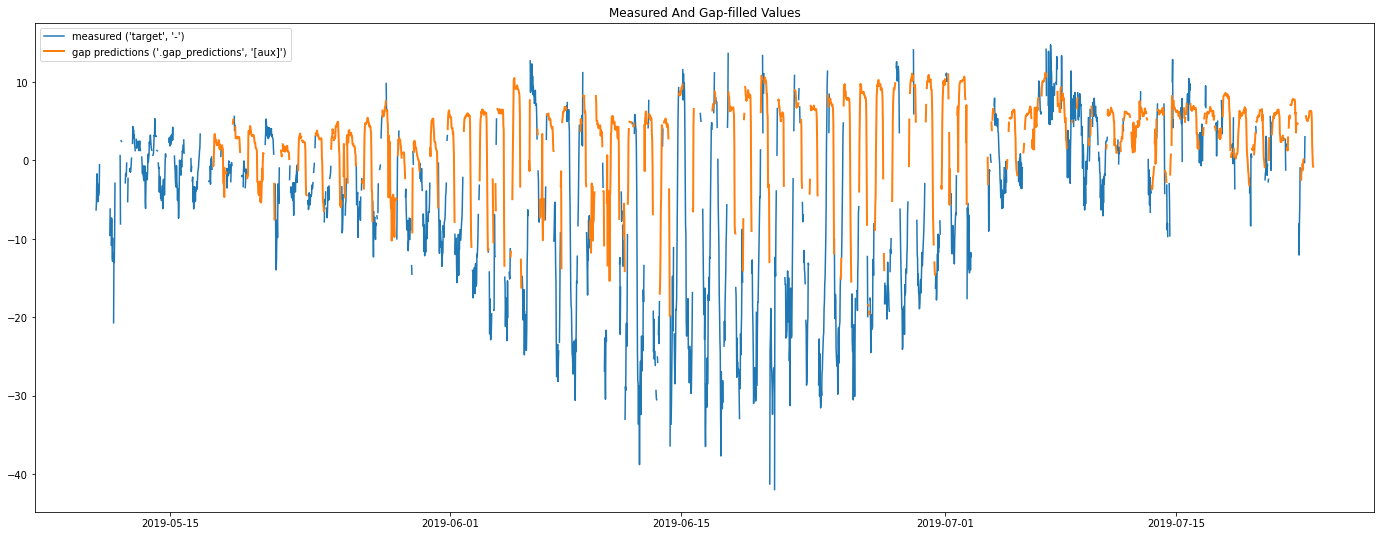

In [69]:
# Plot all targets and predictions
x_col = ('target', '-')
y_col = ('.gap_predictions', '[aux]')
plt.figure(figsize=(24, 9))
plt.title("Measured And Gap-filled Values")
plt.plot(gapfilled_df[x_col], label=f"measured {x_col}")
plt.plot(gapfilled_df[y_col], label=f"gap predictions {y_col}", lw=2)
plt.legend()
plt.show()

### Plot: Gap-filled Time Series

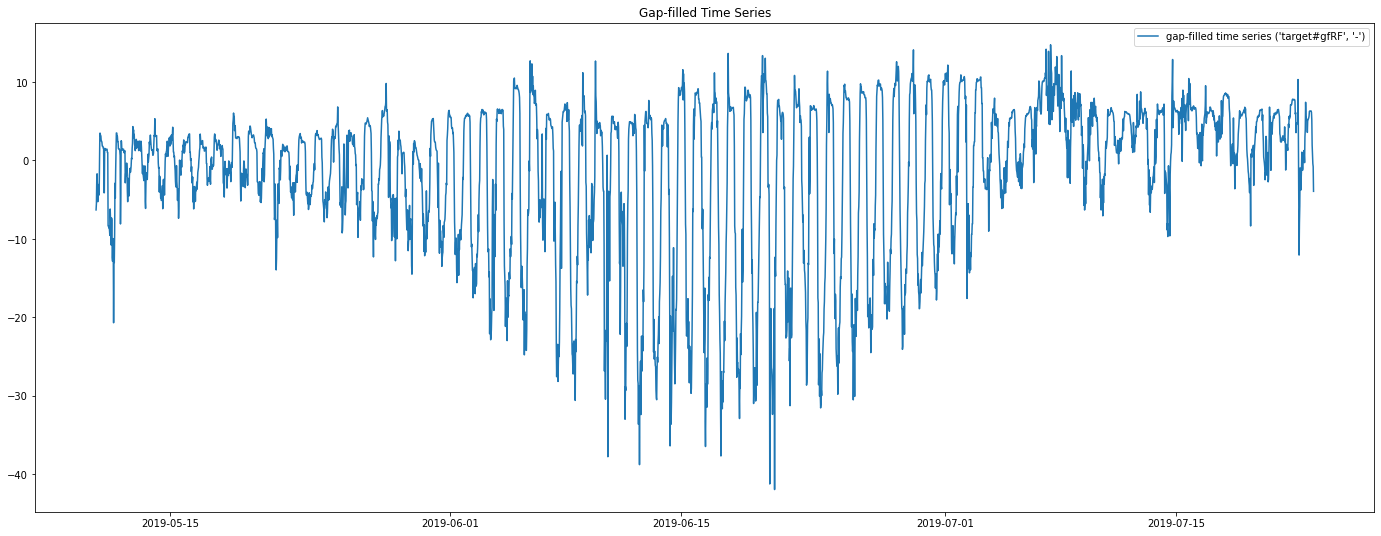

In [70]:
col = ('target#gfRF', '-')
plt.figure(figsize=(24, 9))
plt.title("Gap-filled Time Series")
plt.plot(gapfilled_df[col], label=f"gap-filled time series {col}")
plt.legend()
plt.show()

### Visualize tree

In [71]:
# # Visualize one of the decision trees
# from sklearn.tree import export_graphviz
# import pydot
# tree = rfts.model.estimators_[2]  # # Pull out one tree from the forest
# export_graphviz(tree, out_file = 'tree.dot', feature_names=rfts.feature_names, rounded = True, precision = 1)  # Export the image to a dot file
# (graph, ) = pydot.graph_from_dot_file('tree.dot')  # Use dot file to create a graph
# graph.write_png('tree.png')  # Write graph to a png file

In [72]:
# rfts.feat_reduction_results

## Kudos

- kudos: https://stackoverflow.com/questions/26911851/how-to-use-pandas-to-find-consecutive-same-data-in-time-series
- https://bambielli.com/til/2018-02-11-one-hot-encoding/
- https://www.educative.io/blog/one-hot-encoding#sklearn